In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import pickle
from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [36]:
model_names = []
for mods in glob.glob('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/tcw_hist/prw_Clim20702099-Clim19501999*.nc'):
    tcw_map = xr.open_dataset(mods)
    model_names.append(tcw_map.attrs['model_id'])

In [37]:
model_names

['CESM1-CAM5',
 'MRI-ESM1',
 'MPI-ESM-LR',
 'GFDL-ESM2G',
 'CNRM-CM5',
 'FIO-ESM',
 'GISS-E2-R-CC',
 'CMCC-CESM',
 'CSIRO-Mk3-6-0',
 'HadGEM2-ES',
 'GISS-E2-H',
 'GFDL-ESM2M',
 'CCSM4',
 'CMCC-CM',
 'ACCESS1-0',
 'inmcm4',
 'bcc-csm1-1',
 'MIROC-ESM-CHEM',
 'GISS-E2-H-CC',
 'MRI-CGCM3',
 'IPSL-CM5A-MR',
 'CESM1-BGC',
 'HadGEM2-CC',
 'BNU-ESM',
 'MIROC-ESM',
 'NorESM1-ME',
 'IPSL-CM5A-LR',
 'NorESM1-M',
 'ACCESS1-3',
 'CMCC-CMS',
 'MPI-ESM-MR',
 'bcc-csm1-1-m',
 'IPSL-CM5B-LR',
 'FGOALS-g2',
 'CanESM2',
 'GISS-E2-R',
 'MIROC5',
 'GFDL-CM3']

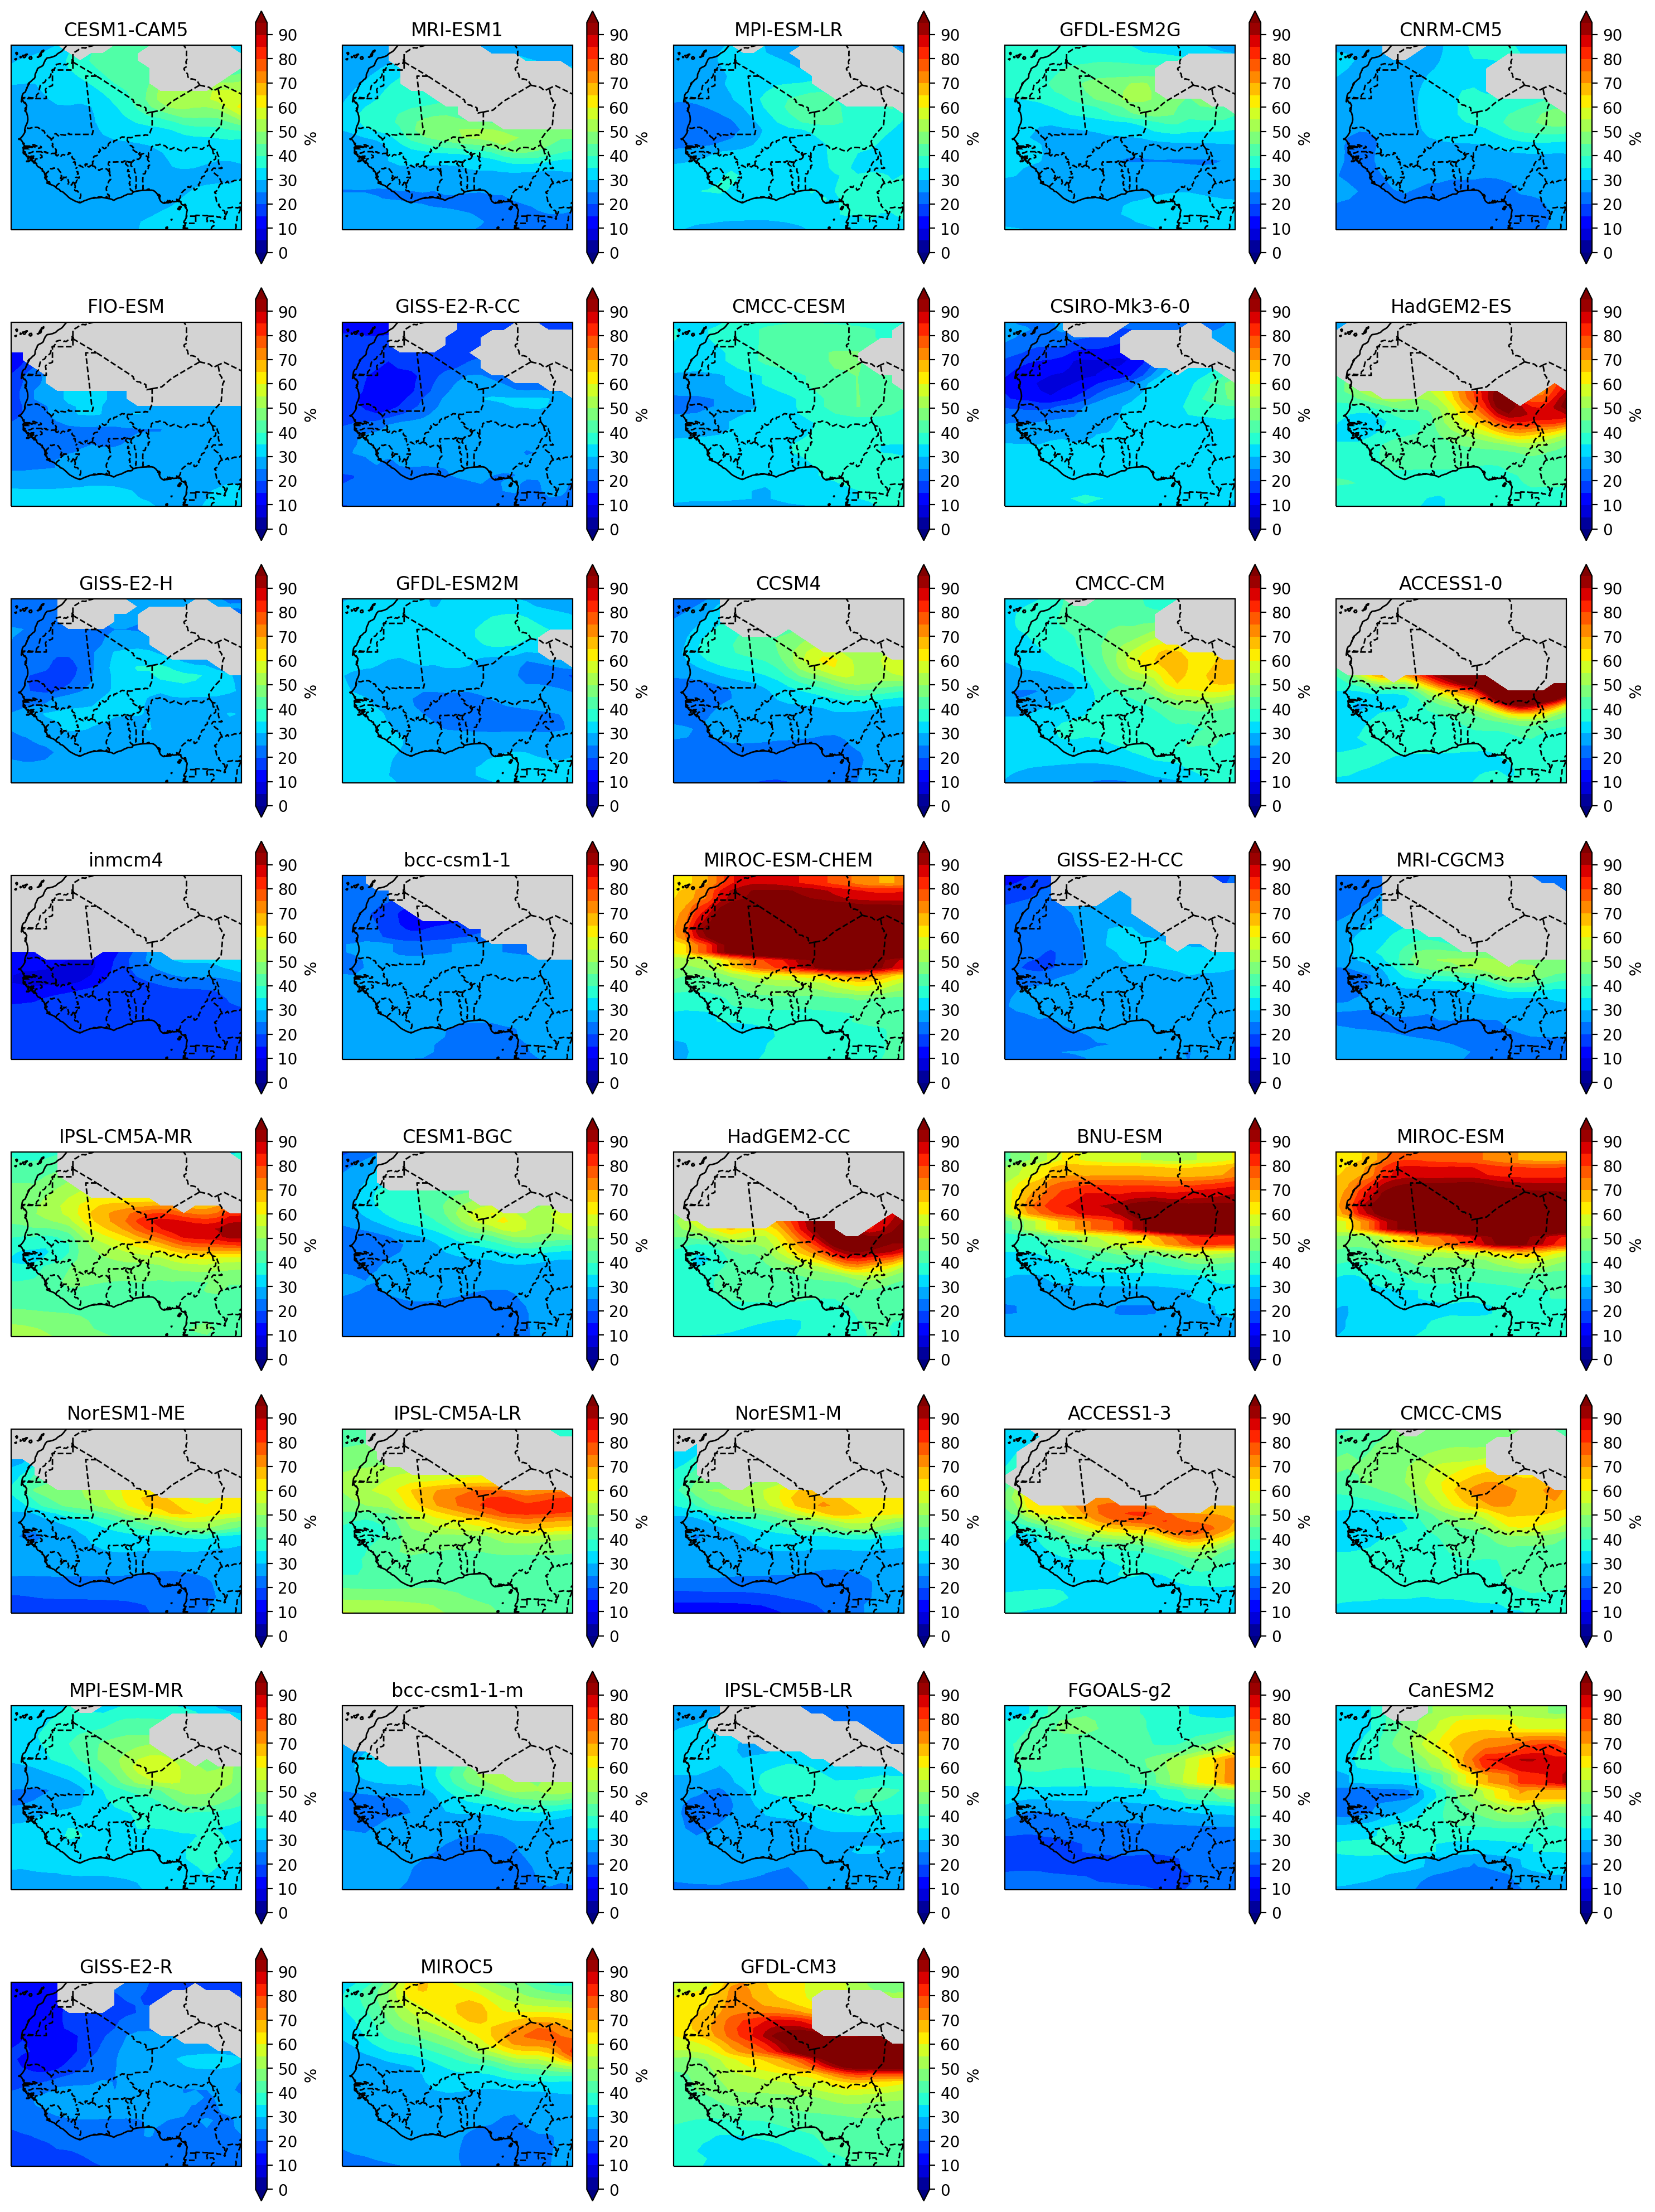

In [40]:
def draw_map(ax, dat, lat, lon, title='', levels=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap='jet', extend='both', levels=levels)
    ax.coastlines()
#     # Gridlines
#     xl = ax.gridlines(draw_labels=True);
#     xl.xlabels_top = False
#     xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_ylim(0,30)
    ax.set_facecolor('lightgrey')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(r'%')

f = plt.figure(figsize=(15,20), dpi=200)
cmip_tcw_wa = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
for num, model in enumerate(model_names):
#for num in range(36):   
    
    cmip = cmip_tcw_wa.sel(model_name=model)
    cmip_tcw_rel = cmip['prw']/cmip['prw_hist']*100
    cmip_tcw_rel = cmip_tcw_rel.sel(lon=slice(-20,20), lat=slice(0,30))
    
    posi = num+1
    
    #ipdb.set_trace()
    
    ax = f.add_subplot(8,5,posi, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    #ipdb.set_trace()
    draw_map(ax, cmip_tcw_rel, cmip_tcw_rel.lat, cmip_tcw_rel.lon, title=cmip_tcw_rel.model_name.values, levels=np.arange(0,100,5))   #[num,:,:]  #.where((cmip['prw_hist']>20) & (np.abs(cmip['prw'])>1))
    
#     ax = f.add_subplot(38,3,posi+1, projection=ccrs.PlateCarree())
#     draw_map(ax, cmip_tcw_wa[num,:,:]/cmip_both[num,:,:]*100, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=str(num))
    
#     ax = f.add_subplot(38,3,posi+2, projection=ccrs.PlateCarree())
#     draw_map(ax, cmip_sh_wa[num,:,:]/cmip_both[num,:,:]*100, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=str(num))

plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/TCW_relativeChange_CMIP.jpg')

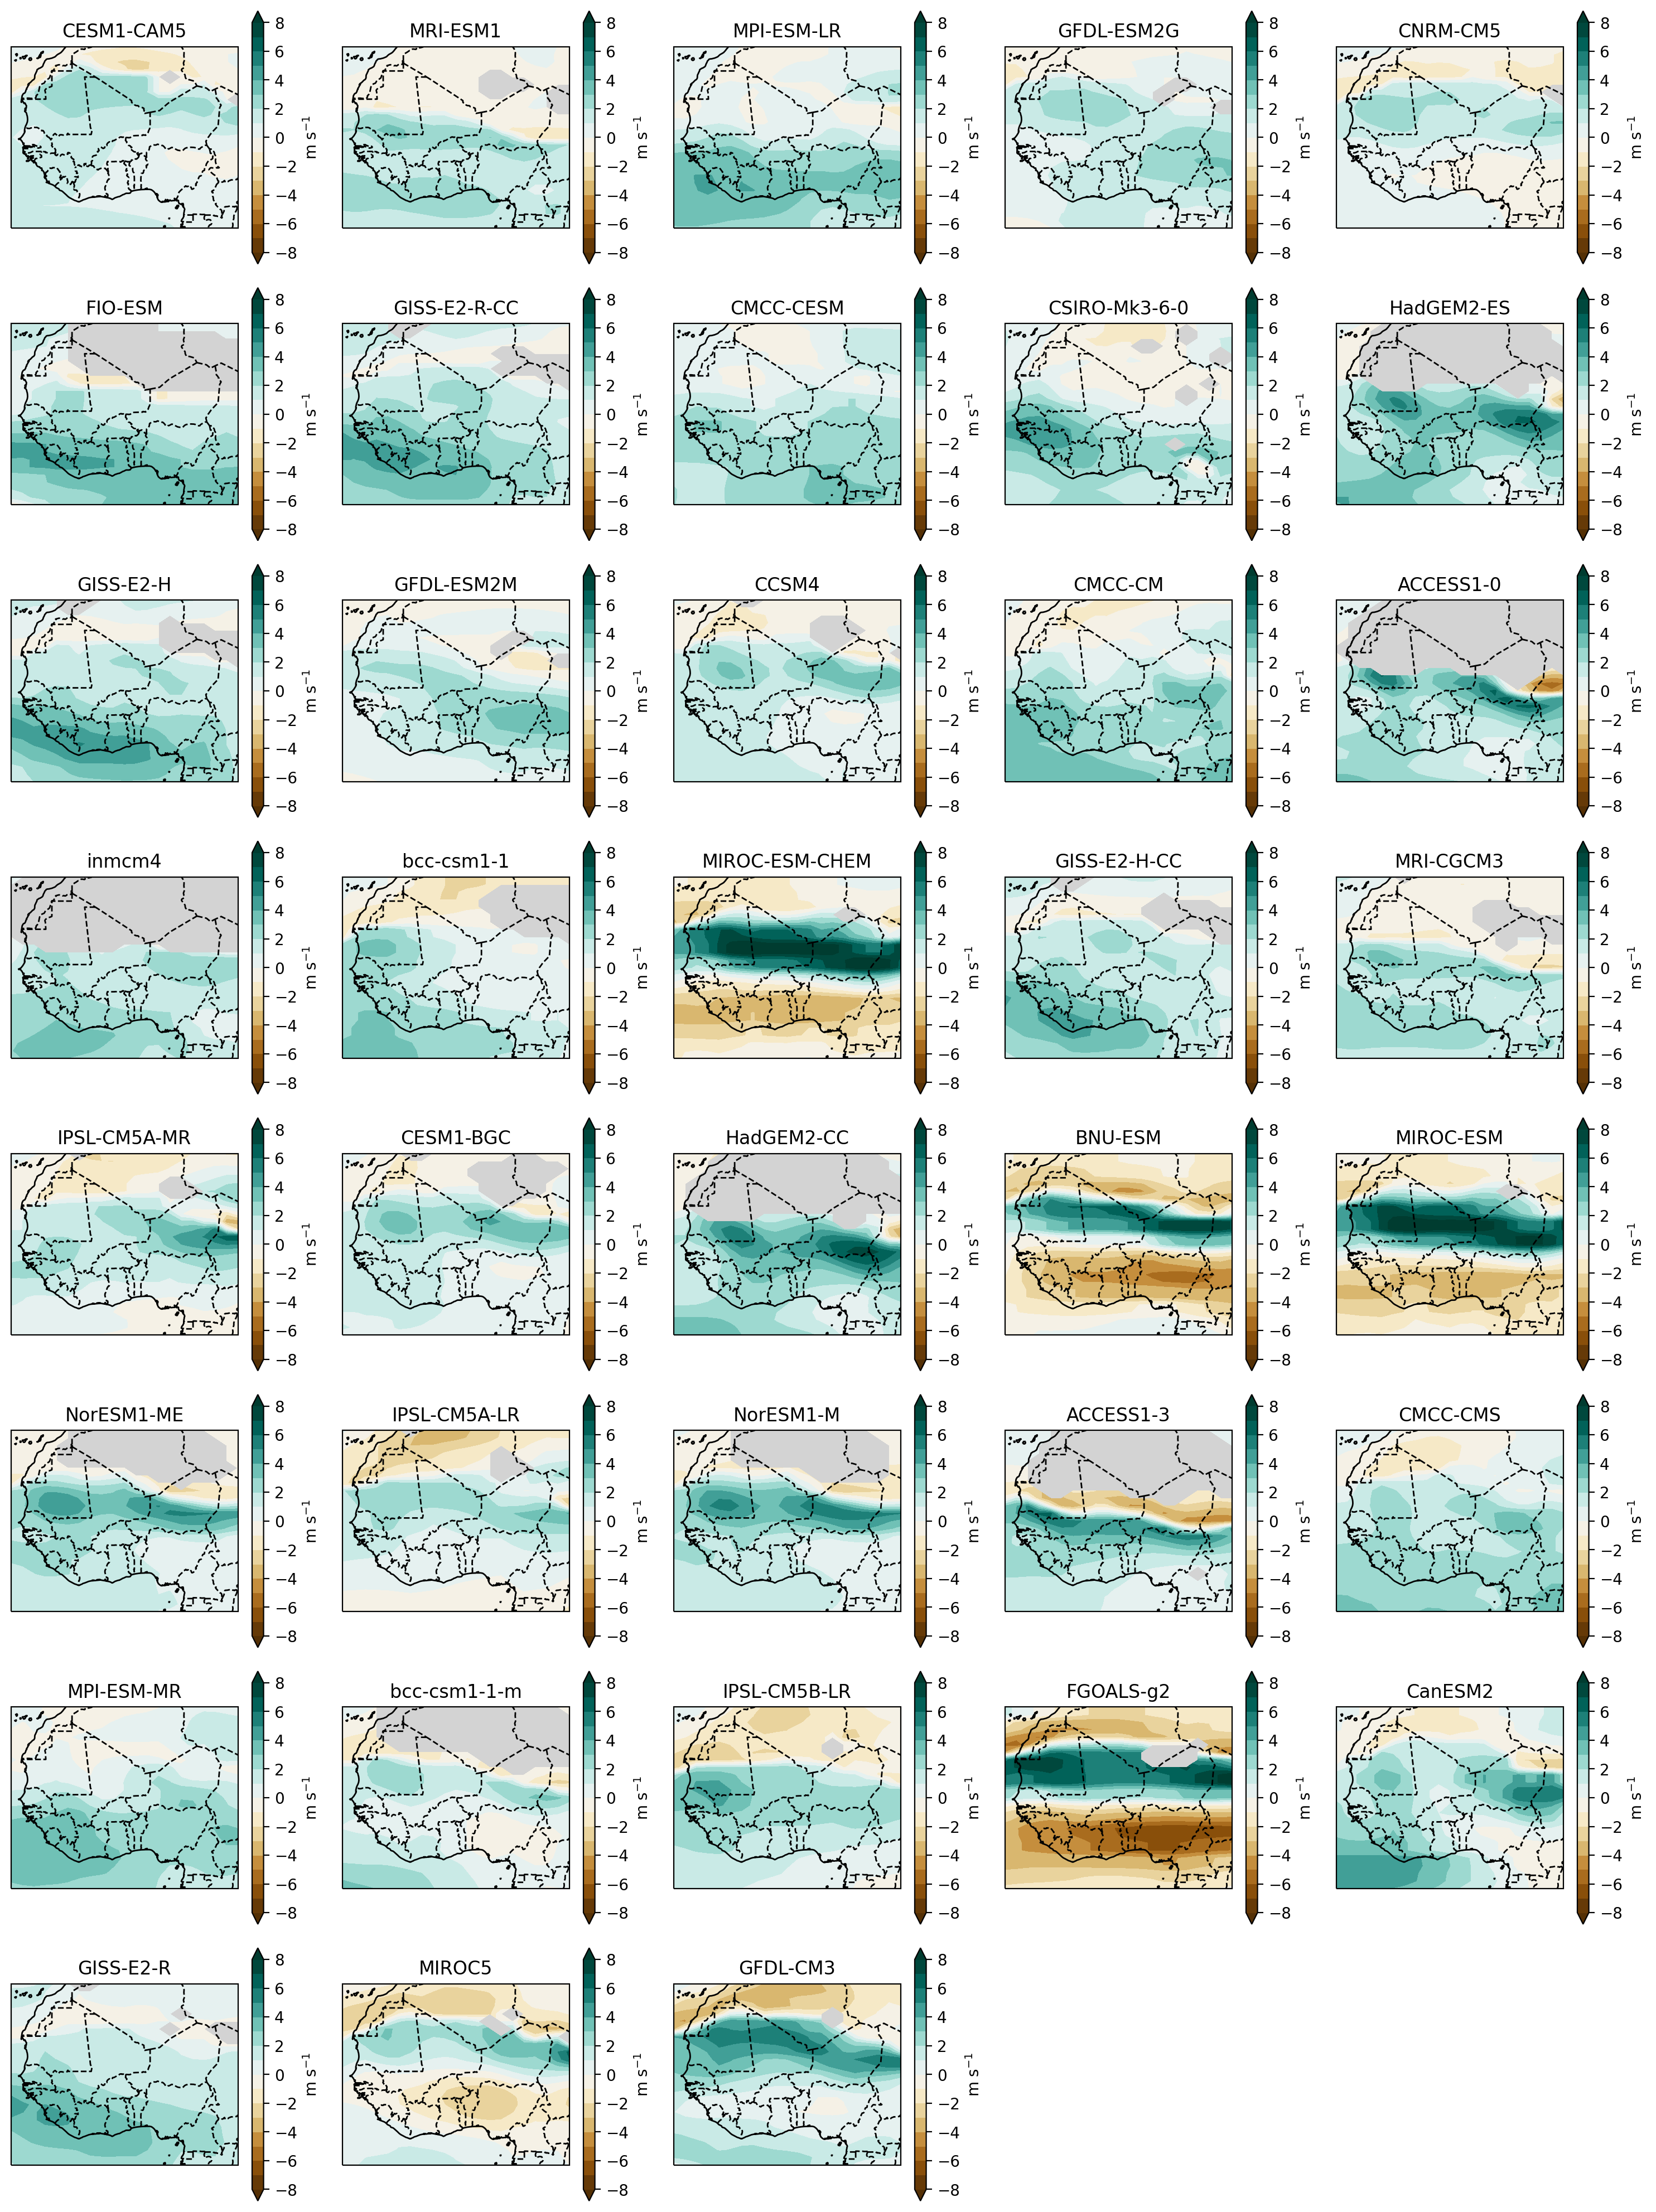

In [17]:
def draw_map(ax, dat, lat, lon, title='', levels=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both', levels=levels)
    ax.coastlines()
#     # Gridlines
#     xl = ax.gridlines(draw_labels=True);
#     xl.xlabels_top = False
#     xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_ylim(0,30)
    plt.title(title)
    ax.set_facecolor('lightgrey')
    cbar = plt.colorbar()
    cbar.set_label(r'm s$^{-1}$')

f = plt.figure(figsize=(15,20), dpi=200)
cmip_tcw_wa = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/u*.nc', concat_dim='model_name', combine='by_coords').load()
for num, model in enumerate(model_names):
#for num in range(36):   
    
    cmip = cmip_tcw_wa.sel(model_name=model)
    cmip_tcw_rel = cmip['unknown']
    cmip_tcw_rel = cmip_tcw_rel.sel(lon=slice(-20,20), lat=slice(0,30))
    
    posi = num+1
    
    #ipdb.set_trace()
    
    ax = f.add_subplot(8,5,posi, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    #ipdb.set_trace()
    draw_map(ax, cmip_tcw_rel, cmip_tcw_rel.lat, cmip_tcw_rel.lon, title=cmip_tcw_rel.model_name.values, levels=np.arange(-8,9,1))   #[num,:,:]
    
#     ax = f.add_subplot(38,3,posi+1, projection=ccrs.PlateCarree())
#     draw_map(ax, cmip_tcw_wa[num,:,:]/cmip_both[num,:,:]*100, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=str(num))
    
#     ax = f.add_subplot(38,3,posi+2, projection=ccrs.PlateCarree())
#     draw_map(ax, cmip_sh_wa[num,:,:]/cmip_both[num,:,:]*100, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=str(num))

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/SHEAR_relativeChange_CMIP.jpg')

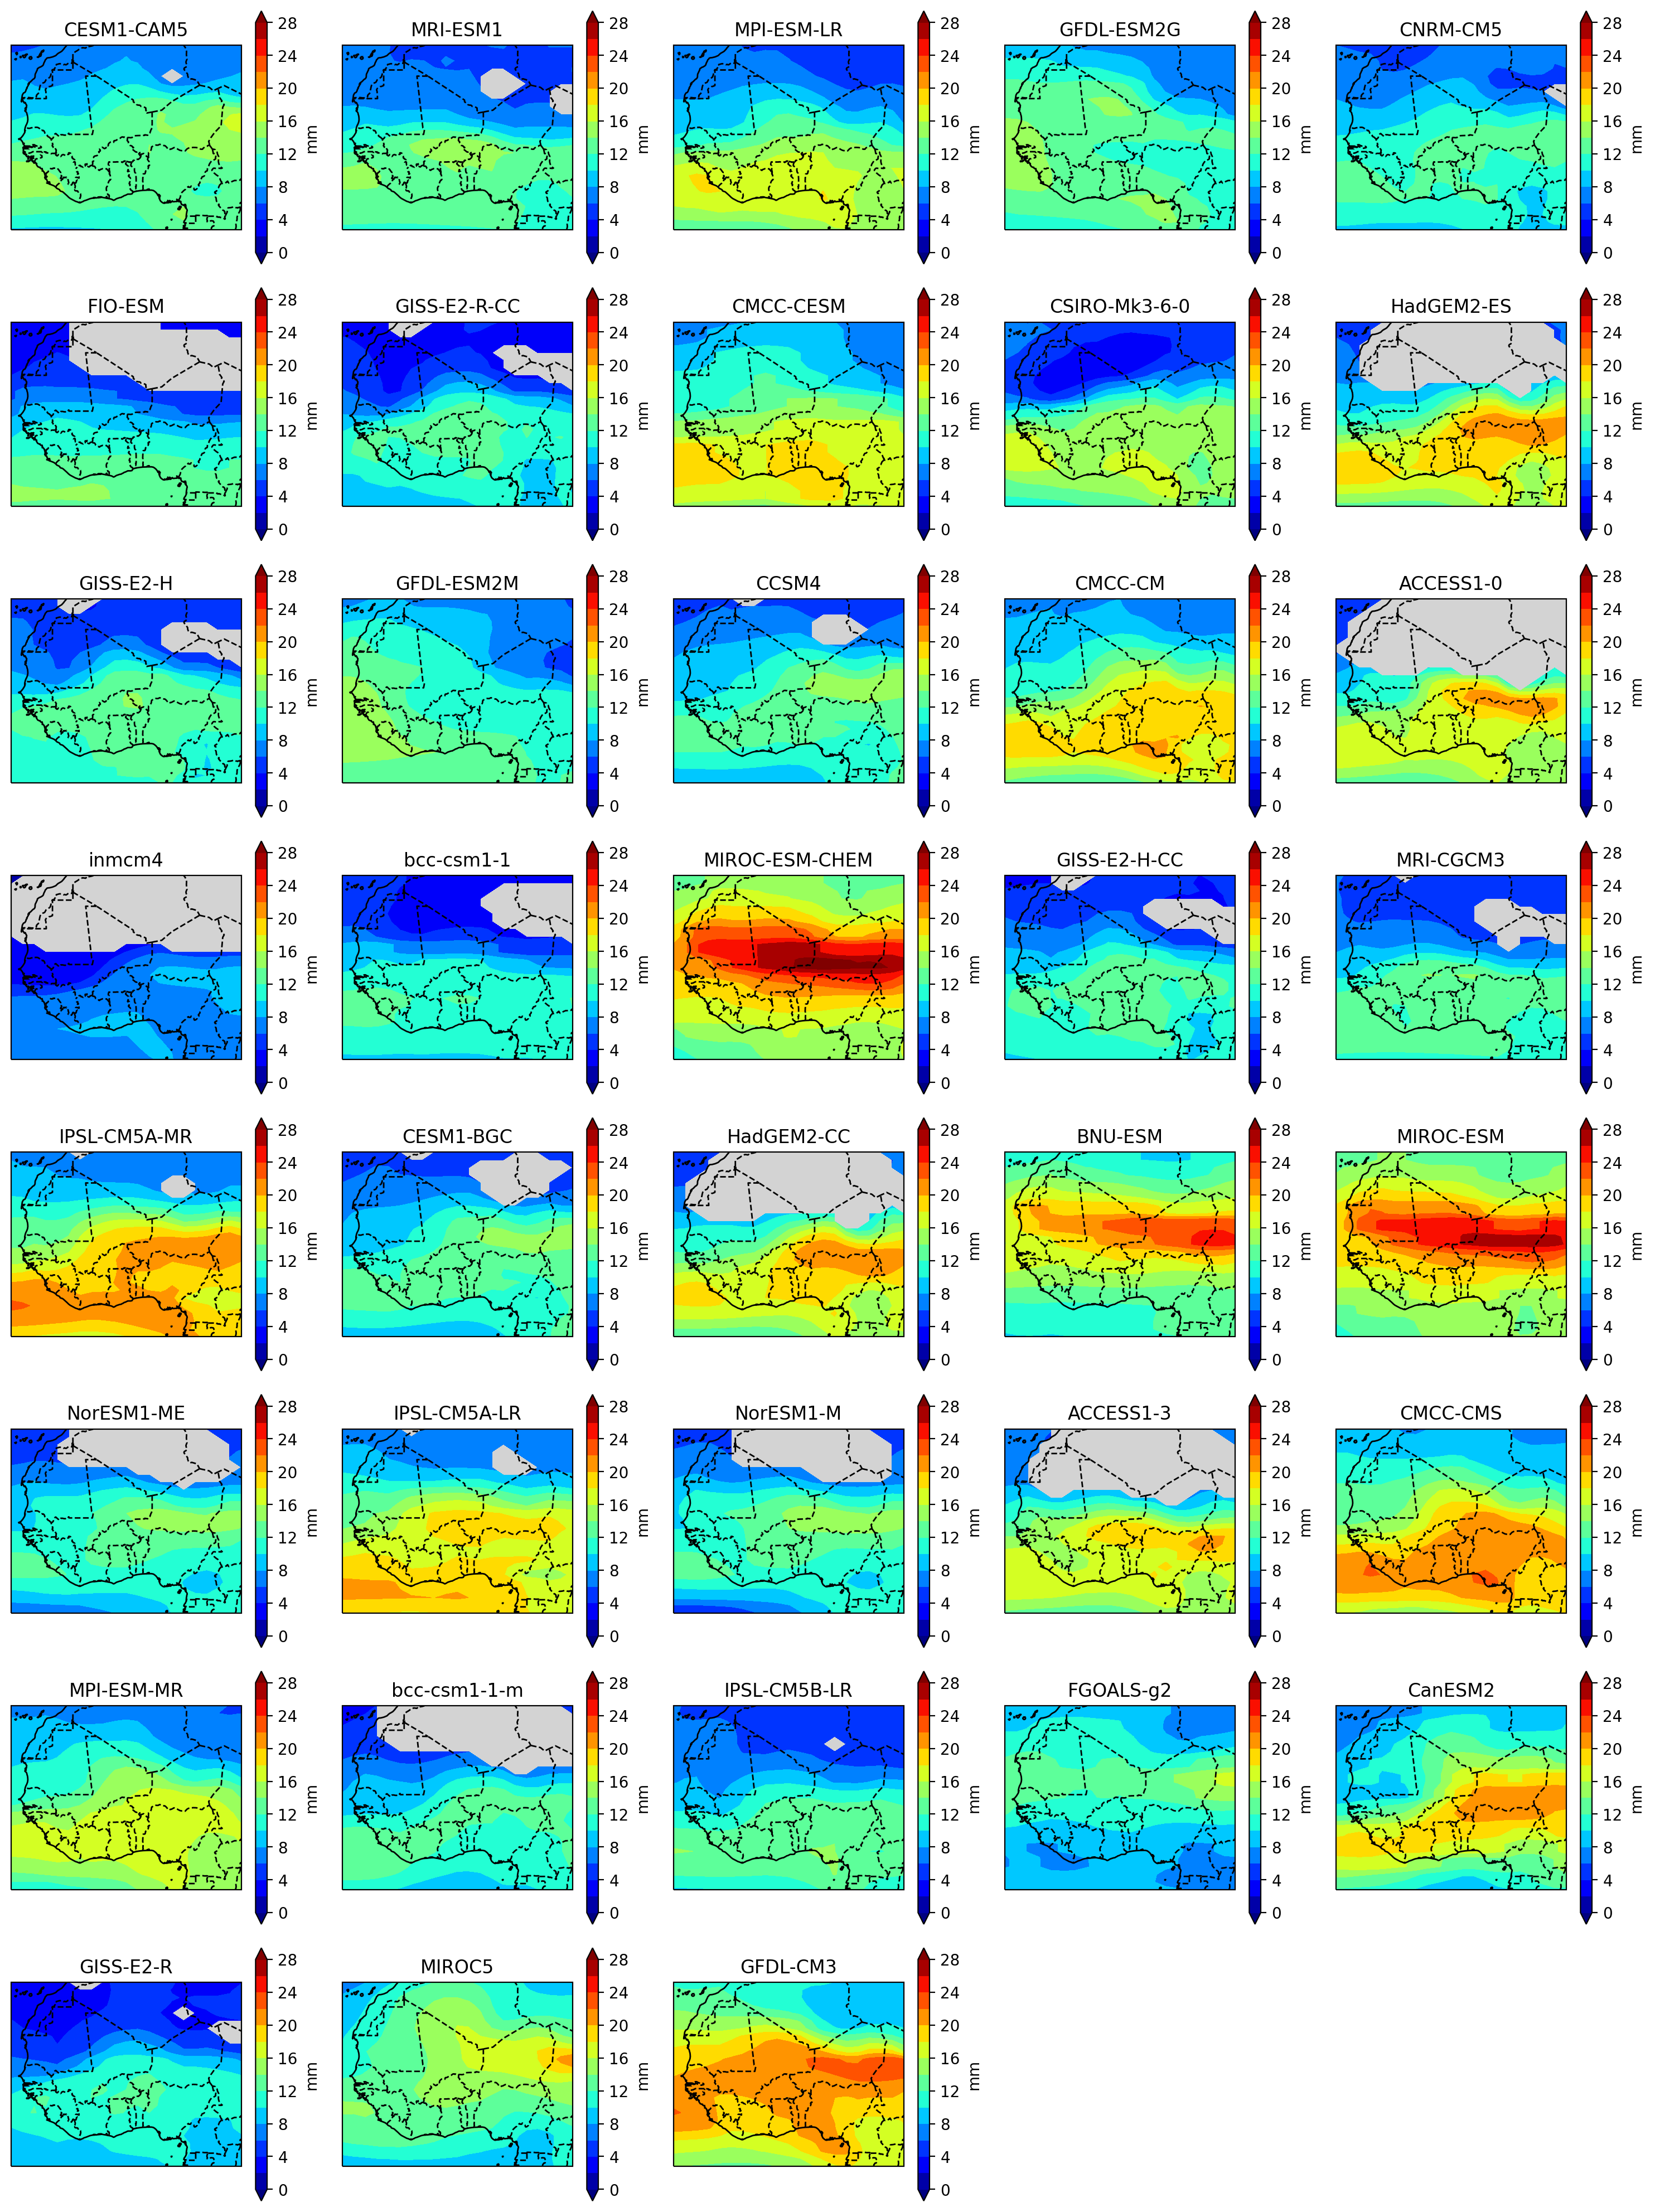

In [19]:
def draw_map(ax, dat, lat, lon, title='', levels=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap='jet', extend='both', levels=levels)
    ax.coastlines()
#     # Gridlines
#     xl = ax.gridlines(draw_labels=True);
#     xl.xlabels_top = False
#     xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_ylim(0,30)
    ax.set_facecolor('lightgrey')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(r'mm')

f = plt.figure(figsize=(15,20), dpi=200)
cmip_tcw_wa = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
for num, model in enumerate(model_names):
#for num in range(36):   
    
    cmip = cmip_tcw_wa.sel(model_name=model)
    cmip_tcw_rel = cmip['prw']
    cmip_tcw_rel = cmip_tcw_rel.sel(lon=slice(-20,20), lat=slice(0,30))
    
    posi = num+1
    
    #ipdb.set_trace()
    
    ax = f.add_subplot(8,5,posi, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    #ipdb.set_trace()
    draw_map(ax, cmip_tcw_rel, cmip_tcw_rel.lat, cmip_tcw_rel.lon, title=cmip_tcw_rel.model_name.values, levels=np.arange(0,30,2))   #[num,:,:]
    
#     ax = f.add_subplot(38,3,posi+1, projection=ccrs.PlateCarree())
#     draw_map(ax, cmip_tcw_wa[num,:,:]/cmip_both[num,:,:]*100, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=str(num))
    
#     ax = f.add_subplot(38,3,posi+2, projection=ccrs.PlateCarree())
#     draw_map(ax, cmip_sh_wa[num,:,:]/cmip_both[num,:,:]*100, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=str(num))

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/TCW_relativeChange_CMIP_totalPRW.jpg')